In [1]:
from keras.layers import Conv2D, UpSampling2D, InputLayer
from keras.models import Sequential
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from skimage.color import rgb2lab, lab2rgb
from skimage.io import imsave
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.datasets import fetch_lfw_people
from tqdm.auto import tqdm
from PIL import Image
import cv2

/Users/andrewermak/anaconda3/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
lfw_people = fetch_lfw_people(min_faces_per_person=50, color=True, 
                              resize=2,
                              slice_=(slice(48, 202), slice(48, 202)))

train = lfw_people.images

In [3]:
print(f'number of examples: {train.shape[0]}')

number of examples: 1560


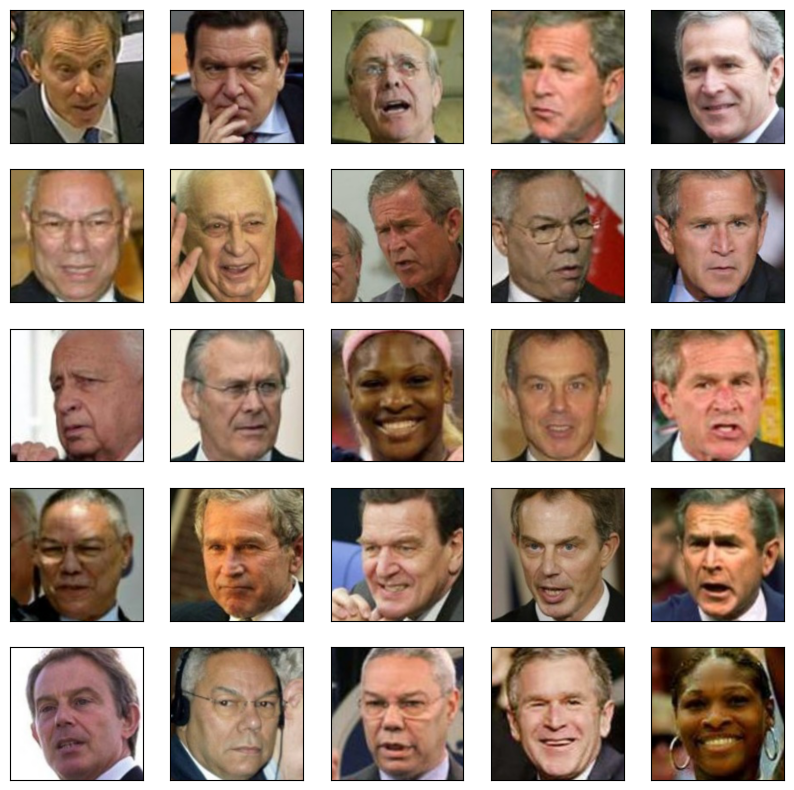

In [4]:
plt.figure(figsize=(10,10))
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(train[i])
plt.show()

In [5]:
def processed_image(image):
    image = cv2.resize(image,(256,256))
    image = np.array(image, dtype=float)
    size = image.shape
    lab = rgb2lab(1.0 / 255*image)
    X, Y = lab[:,:,0], lab[:,:,1:]

    Y /= 128
    X = X.reshape(1, size[0], size[1], 1)
    Y = Y.reshape(1, size[0], size[1], 2)
    return X, Y

X_train = []
Y_train = []

In [6]:
for i in tqdm(train):
    X_train_new, Y_train_new = processed_image(i)
    X_train.append(X_train_new)
    Y_train.append(Y_train_new)

100%|██████████████████████████████████████| 1560/1560 [00:05<00:00, 271.88it/s]


In [7]:
model = Sequential()
model.add(InputLayer(input_shape=(None, None, 1)))
model.add(Conv2D(64, (3, 3), activation='relu', padding='same'))
model.add(Conv2D(64, (3, 3), activation='relu', padding='same', strides=2))
model.add(Conv2D(128, (3, 3), activation='relu', padding='same'))
model.add(Conv2D(128, (3, 3), activation='relu', padding='same', strides=2))
model.add(Conv2D(256, (3, 3), activation='relu', padding='same'))
model.add(Conv2D(256, (3, 3), activation='relu', padding='same', strides=2))
model.add(Conv2D(512, (3, 3), activation='relu', padding='same'))
model.add(Conv2D(256, (3, 3), activation='relu', padding='same'))
model.add(Conv2D(128, (3, 3), activation='relu', padding='same'))
model.add(UpSampling2D((2, 2)))
model.add(Conv2D(64, (3, 3), activation='relu', padding='same'))
model.add(UpSampling2D((2, 2)))
model.add(Conv2D(32, (3, 3), activation='relu', padding='same'))
model.add(Conv2D(2, (3, 3), activation='tanh', padding='same'))
model.add(UpSampling2D((2, 2)))

In [8]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, None, None, 64)    640       
                                                                 
 conv2d_1 (Conv2D)           (None, None, None, 64)    36928     
                                                                 
 conv2d_2 (Conv2D)           (None, None, None, 128)   73856     
                                                                 
 conv2d_3 (Conv2D)           (None, None, None, 128)   147584    
                                                                 
 conv2d_4 (Conv2D)           (None, None, None, 256)   295168    
                                                                 
 conv2d_5 (Conv2D)           (None, None, None, 256)   590080    
                                                                 
 conv2d_6 (Conv2D)           (None, None, None, 512)   1

In [9]:
model.compile(optimizer='adam', loss='mse')

In [10]:
for n in range(len(X_train)):
    if n % 100 == 0 or n == 1:
        print(f'Iteration: {n}')
    model.fit(x=X_train[n], y=Y_train[n], batch_size=1, epochs=50, verbose=False)

Iteration: 0
Iteration: 1
Iteration: 100
Iteration: 200
Iteration: 300
Iteration: 400
Iteration: 500
Iteration: 600
Iteration: 700
Iteration: 800
Iteration: 900
Iteration: 1000
Iteration: 1100
Iteration: 1200
Iteration: 1300
Iteration: 1400
Iteration: 1500


In [11]:
img = tf.io.read_file('my_photo.jpg')
img = tf.image.decode_jpeg(img)
X, Y = processed_image(img.numpy())

In [12]:
output = model.predict(X)

1/1 [==============================] - 0s 220ms/step


In [13]:
output *= 128
min_vals, max_vals = -128, 127
ab = np.clip(output[0], min_vals, max_vals)

In [14]:
cur = np.zeros((256, 256, 3))
cur[:,:,0] = np.clip(X[0][:,:,0], 0, 100)
cur[:,:,1:] = ab

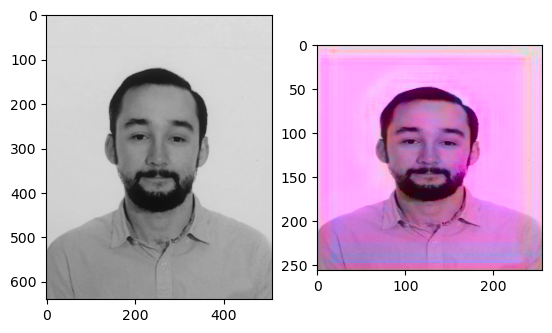

In [15]:
plt.subplot(1, 2, 1)
plt.imshow(img)
plt.subplot(1, 2, 2)
plt.imshow(lab2rgb(cur))